In [7]:
import matplotlib as mpl
mpl.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'

In [8]:
import matplotlib as mpl
from matplotlib import animation
print(animation.writers.list())

import numpy as np
import matplotlib.pyplot as plt

#from numpy import *
from matplotlib import rc

rc('font', family='serif', size=14)
rc('lines', linewidth=1.5)

['pillow', 'ffmpeg', 'ffmpeg_file', 'html']


In [2]:
# 1D Eulerian Advection (nonconservative form), periodic domain
#   u_t + a(x) u_x = 0,  x in [0,L), periodic
# - u0_mat: (N, M) initial ensemble
# - RK4 + first-order upwinding + CFL-based dt
# - outputs stored on t_uniform
# - compressibility + local compressibility + POD drift

In [16]:
L = 1.0
N = 512
x_grid = np.linspace(0.0, L, N, endpoint=False)
dx = L / N

CFL = 0.6
tEnd = 1.0
eps = 0.0

# Uniform time grid for output storage
nt_uniform = 500
t_uniform = np.linspace(0.0, tEnd, nt_uniform)

In [4]:
def periodized_gaussian_1d(x, mu, sigma, L):
    return (np.exp(-((x - mu)/sigma)**2)
          + np.exp(-((x - (mu - L))/sigma)**2)
          + np.exp(-((x - (mu + L))/sigma)**2))

In [6]:
# Static Gaussian advection speed a(x) (known mean/variance)
mu_a = 0.60 * L
sigma_a = 0.18 * L
a_base = 0.55
a_amp  = 0.55

a_adv = a_base + a_amp * periodized_gaussian_1d(x_grid, mu_a, sigma_a, L)
a_adv = np.asarray(a_adv, dtype=np.float64)

In [15]:
# First-order upwind derivative (periodic) + RHS
def dudx_upwind_first(u, a_vec, dx):
    """
    u: (N,) array
    a_vec: (N,) array (here static)
    returns u_x using first-order upwind, periodic via np.roll
    """
    uR = np.roll(u, -1)
    uL = np.roll(u,  1)
    dudx_pos = (u - uL) / dx
    dudx_neg = (uR - u) / dx
    return np.where(a_vec >= 0.0, dudx_pos, dudx_neg)

In [18]:
def rhs(u, a_field, dx, t, eps):
    # eps=0 => a_vec == a_field
    a_vec = a_field * np.exp(-eps * t) # eps = 0
    ux = dudx_upwind_first(u, a_vec, dx)
    return -a_vec * ux

In [19]:
# Single simulation function (RK4 + CFL dt)
def run_single_simulation(u0_1d, x_grid, a_field_1d,
                          CFL, dx, tEnd, t_uniform,
                          eps):

    u       = np.array(u0_1d, dtype=np.float64)         # (N,)
    a_field = np.array(a_field_1d, dtype=np.float64)    # (N,)
    N       = u.shape[0]

    # Histories
    t_hist = [0.0]
    u_hist = [u.copy()]
    dt_hist = []

    t = 0.0
    while t < tEnd:
        # CFL dt based on max speed (here constant since eps=0, copied from a(x, t) version)))
        a_vec = a_field * np.exp(-eps * t)
        a_max = float(np.max(np.abs(a_vec)))

        if a_max > 0.0:
            dt_cfl = CFL * dx / a_max
        else:
            dt_cfl = tEnd - t

        remaining = tEnd - t
        if remaining <= 0.0:
            break

        dt = min(dt_cfl, remaining)
        dt_hist.append(dt)

        # RK4
        k1 = rhs(u,               a_field, dx, t,           eps)
        k2 = rhs(u + 0.5*dt*k1,   a_field, dx, t + 0.5*dt,  eps)
        k3 = rhs(u + 0.5*dt*k2,   a_field, dx, t + 0.5*dt,  eps)
        k4 = rhs(u +       dt*k3, a_field, dx, t + dt,      eps)

        u = u + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)
        t = t + dt

        t_hist.append(t)
        u_hist.append(u.copy())

    # Convert histories
    t_hist_np = np.array(t_hist, dtype=np.float64)          # (Nt+1,)
    U_hist_np = np.stack(u_hist, axis=0).astype(np.float64) # (Nt+1, N)
    dt_hist_np = np.array(dt_hist, dtype=np.float64)        # (Nt,)

    # Interpolate to uniform output times
    t_uniform = np.asarray(t_uniform, dtype=np.float64)
    nT = t_uniform.size

    u_uniform = np.empty((N, nT), dtype=np.float64)
    for i in range(N):
        u_uniform[i, :] = np.interp(t_uniform, t_hist_np, U_hist_np[:, i])

    return u_uniform, t_hist_np, U_hist_np, dt_hist_np


# Compressibility of ICs


In [9]:
M = 100 # no. of initial conditions

In [11]:
def periodized_gaussian_batch(x, mu, sigma, L):
    # x: (N,), mu,sigma: (M,)
    X = x[:, None]          # (N,1)
    MU = mu[None, :]        # (1,M)
    S  = sigma[None, :]     # (1,M)
    return (np.exp(-((X - MU)/S)**2)
          + np.exp(-((X - (MU - L))/S)**2)
          + np.exp(-((X - (MU + L))/S)**2))  # (N,M)

In [10]:
rs = np.random.RandomState(300)

mu     = rs.uniform(0.0, L,  size=M)              # U[0,L]
sigma  = rs.uniform(0.025*L, 0.05*L, size=M)      # U[0.025L,0.05L]
amp    = rs.uniform(0.95, 1.0, size=M)            # U[0.95,1.0]

mu = np.asarray(mu)
sigma = np.asarray(sigma)
amp = np.asarray(amp)

g = periodized_gaussian_batch(x_grid, mu, sigma, L)     # (N,M)
u0_mat = 1.0 + (g * amp[None, :])                      # (N,M)
u0_mat = np.asarray(u0_mat, dtype=np.float64)

In [12]:
# SVD + 99.99% energy rank
def svd_energy_rank(A, energy=0.9999):
    U, S, Vh = np.linalg.svd(A, full_matrices=False)
    s2 = S**2
    cum = np.cumsum(s2)
    r = int(np.searchsorted(cum, energy * s2.sum()) + 1)
    U_r = U[:, :r]
    return r, U_r, S

In [13]:
r_u0, U_u0, S_u0 = svd_energy_rank(u0_mat, energy=0.9999)
print("Ranks for 99.99% cumulative energy:")
print("  u0   :", float(r_u0))

Ranks for 99.99% cumulative energy:
  u0   : 28.0


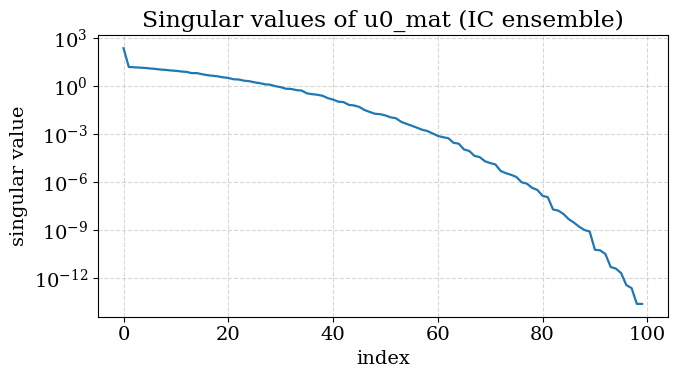

In [14]:
plt.figure(figsize=(7,4))
plt.semilogy(S_u0, lw=1.6)
plt.title("Singular values of u0_mat (IC ensemble)")
plt.xlabel("index")
plt.ylabel("singular value")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Run All Simulation Parallel

In [20]:
from joblib import Parallel, delayed

In [21]:
def run_all_simulations_parallel(u0_mat, x_grid, a_adv,
                                 CFL, dx, tEnd, t_uniform,
                                 eps,               # <-- NEW
                                 n_jobs=-1):
    """
    Run one advection simulation per initial condition (column of u0_mat)
    in parallel using joblib.

    PDE: u_t + a(x,t) u_x = 0, periodic BC.
         a(x,t) = a_adv(x) * exp(-eps * t)

    a_adv(x) is a single, precomputed advection field shared by all ICs.
    """
    N, M = u0_mat.shape
    print(f"Launching {M} independent simulations using {n_jobs} workers...")

    # ---- Ensure data are NumPy arrays for joblib ----
    u0_mat_host = np.asarray(u0_mat)
    a_adv_host  = np.asarray(a_adv)
    x_grid_host = np.asarray(x_grid)

    # Inside joblib we are on CPU / NumPy
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(run_single_simulation)(
            u0_mat_host[:, m],   # IC m (size N)
            x_grid_host,         # grid
            a_adv_host,          # same advection field for all ICs
            CFL, dx, tEnd, t_uniform,
            eps                  # <-- pass eps through
        )
        for m in range(M)
    )

    # Each result: (u_uniform, t_hist, U_hist, dt_hist)
    u_uniform_list, t_hist_list, U_hist_list, dt_hist_list = zip(*results)

    print("\nSimulation summary:")
    for i, dt_hist in enumerate(dt_hist_list):
        # if dt_hist[0] = 0.0 and has length Nt+1:
        nsteps = len(dt_hist) - 1
        print(f"  IC {i:3d}: {nsteps:5d} time steps")

    return (list(u_uniform_list),
            list(t_hist_list),
            list(U_hist_list),
            list(dt_hist_list))

In [23]:
# Suppose you already built u0_mat (N, M) with periodized_gaussian_batch

N, M = u0_mat.shape
dx = L / N
tEnd = 1.0
t_uniform = np.linspace(0.0, tEnd, 500)

# Build Eulerian grid if not already
x_grid = np.linspace(0.0, L, N, endpoint=False)
#a_adv = a_field    # (N,) precomputed advection speed

# a_adv should be defined earlier, e.g.
# a_adv = some_function_of_x(x_grid)

u_uniform_list, t_hist_list, U_hist_list, dt_hist_list = run_all_simulations_parallel(
    u0_mat,           # (N, M)
    x_grid,           # (N,)
    a_adv,            # (N,) precomputed advection speed
    CFL=CFL,
    dx=dx,
    tEnd=tEnd,
    t_uniform=t_uniform,
    eps=eps,          # <-- pass eps through
    n_jobs=-1
)

print(f"Completed {len(u_uniform_list)} simulations.")
print("u_uniform shape  IC 0:", u_uniform_list[0].shape)   # (N, nT)
print("t_hist shape     IC 0:", t_hist_list[0].shape)      # (Nt+1,)
print("U_hist shape     IC 0:", U_hist_list[0].shape)      # (Nt+1, N)
print("dt_hist shape    IC 0:", dt_hist_list[0].shape)     # (Nt,)

Launching 100 independent simulations using -1 workers...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.4s



Simulation summary:
  IC   0:   938 time steps
  IC   1:   938 time steps
  IC   2:   938 time steps
  IC   3:   938 time steps
  IC   4:   938 time steps
  IC   5:   938 time steps
  IC   6:   938 time steps
  IC   7:   938 time steps
  IC   8:   938 time steps
  IC   9:   938 time steps
  IC  10:   938 time steps
  IC  11:   938 time steps
  IC  12:   938 time steps
  IC  13:   938 time steps
  IC  14:   938 time steps
  IC  15:   938 time steps
  IC  16:   938 time steps
  IC  17:   938 time steps
  IC  18:   938 time steps
  IC  19:   938 time steps
  IC  20:   938 time steps
  IC  21:   938 time steps
  IC  22:   938 time steps
  IC  23:   938 time steps
  IC  24:   938 time steps
  IC  25:   938 time steps
  IC  26:   938 time steps
  IC  27:   938 time steps
  IC  28:   938 time steps
  IC  29:   938 time steps
  IC  30:   938 time steps
  IC  31:   938 time steps
  IC  32:   938 time steps
  IC  33:   938 time steps
  IC  34:   938 time steps
  IC  35:   938 time steps
  IC  3

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished


In [24]:
x_grid.shape

(512,)

In [25]:
u_hist_param = u_uniform_list
u_hist_param[2].shape

(512, 500)

In [26]:
u_hist_tensor = np.asarray(u_hist_param, dtype=np.float64)

In [27]:
u_hist_tensor.shape

(100, 512, 500)

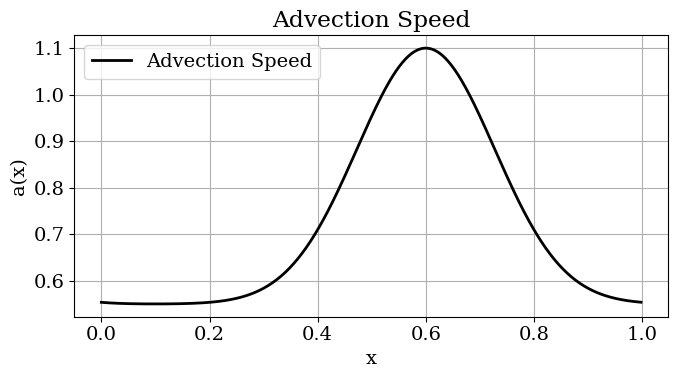

In [28]:
plt.figure(figsize=(7,4))
plt.plot(x_grid, a_adv, 'k-', lw=2, label='Advection Speed')
plt.xlabel('x')
plt.ylabel('a(x)')
plt.title('Advection Speed')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
# We are checking local compression for 200th timestep out of 500 timesteps

u_local = np.transpose(u_hist_tensor[:,:, 400])
r_u,   U_u,   S_u   = svd_energy_rank(u_local)

# ---- report (bring tiny scalars to host for printing if on GPU) ----
to_host = (lambda v: float(v))
print("Ranks for 99.99% cumulative energy:")

print("  u    :", to_host(r_u))

Ranks for 99.99% cumulative energy:
  u    : 15.0


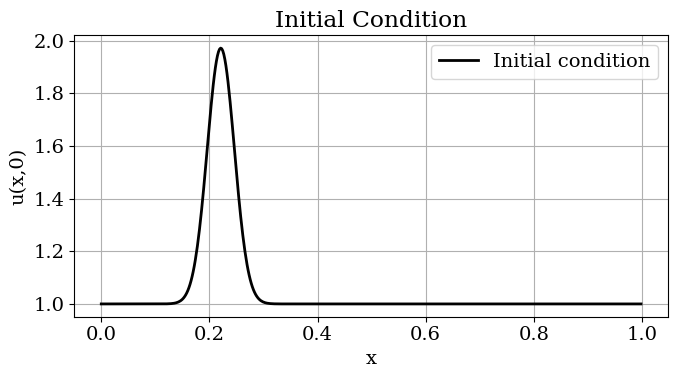

In [31]:
plt.figure(figsize=(7,4))
plt.plot(x_grid, u_hist_tensor[1, :, 0 ], 'k-', lw=2, label='Initial condition')
plt.xlabel('x')
plt.ylabel('u(x,0)')
plt.title('Initial Condition')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Observation:
If we change the timestep values, the rank does not change. Becuase nothing interesting is happening. everything is just moving to the right.

## Build local basis at each timestep.

In [34]:
r = 30
nt = t_uniform.shape[0]

# history tensors: (nx, M, nt)
# rho_hist_tensor, u_hist_tensor, p_hist_tensor, phi_hist_tensor
results_u   = []
Vr_u_hist   = []
u_hat_hist = []

# --- loop over time ---
for it in range(nt):
    # Take snapshot matrices across all ICs at a given time
    u_local   = np.transpose(u_hist_tensor[:, :, it])

    # Compute SVDs (on GPU)
    U_u,   S_u,   _ = np.linalg.svd(u_local)#,   full_matrices=False)

    # Initialize lists for errors at this timestep
    errs_u = []

    # --- loop over rank values ---
    Vr_u   = U_u[:, :r]
    u_hat = Vr_u.T @ u_local
    Vr_u_hist.append(Vr_u)
    u_hat_hist.append(u_hat)

In [35]:
u_hat.shape

(30, 100)

## Calculate Misalignment between two local POD bases

In [36]:
def subspace_drift(V_hist):
    """
    Compute subspace misalignment between consecutive POD bases for ALL timesteps.
    Includes boundary handling for first and last timesteps.

    Returns:
        E_minus, E_plus : arrays of shape (nt,)
    """
    nt = len(V_hist)
    E_minus = np.zeros(nt)
    E_plus  = np.zeros(nt)
    I = np.eye(V_hist[0].shape[0], dtype=V_hist[0].dtype)

    for i in range(nt):
        V_curr = V_hist[i]

        # previous projection
        if i > 0:
            V_prev = V_hist[i - 1]
            P_prev = V_prev @ V_prev.T
            E_minus[i] = np.linalg.norm((I - P_prev) @ V_curr, 'fro')
        else:
            E_minus[i] = np.nan  # no previous step

        # next projection
        if i < nt - 1:
            V_next = V_hist[i + 1]
            P_next = V_next @ V_next.T
            E_plus[i] = np.linalg.norm((I - P_next) @ V_curr, 'fro')
        else:
            E_plus[i] = np.nan  # no next step

    return E_minus, E_plus

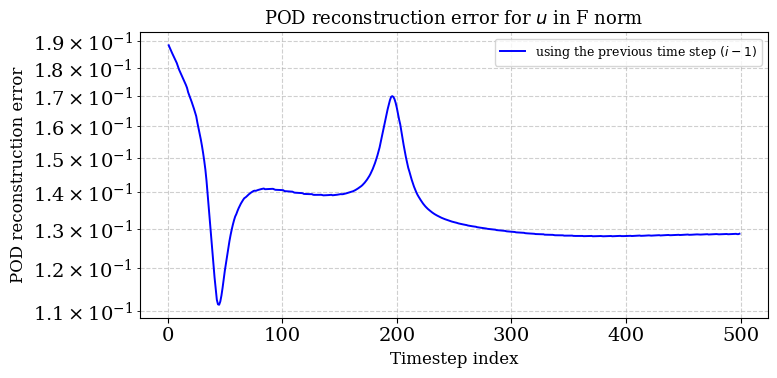

In [37]:
# --- Compute subspace drifts for each variable ---
Eminus_u, Eplus_u = subspace_drift(Vr_u_hist)

# --- Plot setup (now already NumPy) ---
fields = [
    (Eminus_u, Eplus_u, r'$u$'),
]

for (Eminus, Eplus, field_label) in fields:
    plt.figure(figsize=(8, 4))
    plt.semilogy(Eminus, 'b-', lw=1.4,
                 label=fr"using the previous time step $(i-1)$")
    # plt.semilogy(Eplus, 'r--', lw=1.4,
    #              label=fr"using the next time step $(i+1)$")

    plt.xlabel("Timestep index", fontsize=12)
    plt.ylabel("POD reconstruction error", fontsize=12)
    plt.title(fr"POD reconstruction error for {field_label} in F norm",
              fontsize=13)
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.legend(fontsize=9)
    plt.tight_layout()
    plt.show()

# Inverting for a(x)

## First attempt: Assume we know the structure of a(x)

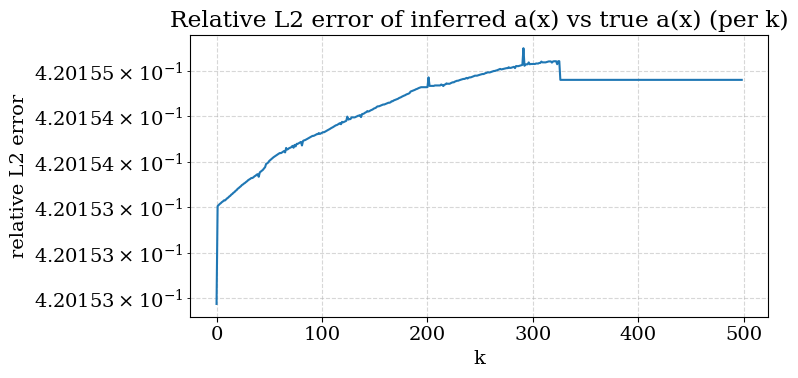

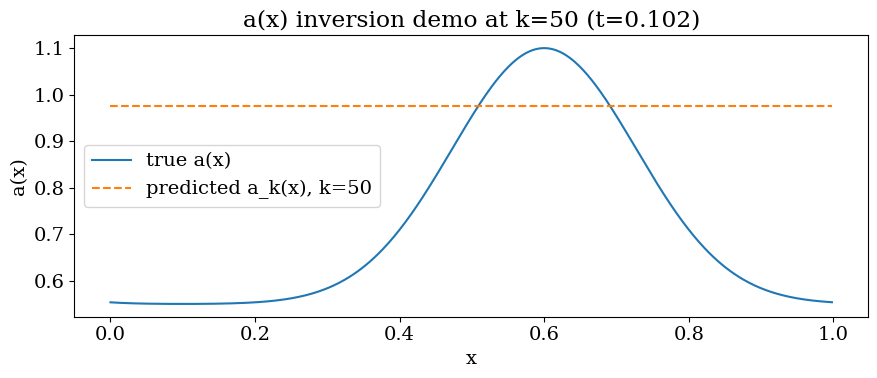

k_plot=50 | rel_err=4.202e-01
true_theta   = [0.55 0.55 0.6  0.18]
theta_hat[k] = [9.74599752e-01 1.08333073e-05 5.80274810e-01 5.00000000e-01]


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ============================================================
# Invert a(x) per time step k by maximizing
#   || V_{k+1}^T T_k(a) V_k ||_F
#
# T_k(a) uses semi-Lagrangian departure points obtained by
# backward-Euler characteristic equation:
#   x_dep = x - dt_k * a(x_dep) * exp(-eps * t_{k+1})
#
# We parameterize a(x) by theta=[a_base, a_amp, mu, sigma]:
#   a(x;theta) = a_base + a_amp * periodic_gaussian(x; mu, sigma)
# ============================================================

# ----------------------------
# Periodized Gaussian + parameterized a(x)
# ----------------------------
def periodic_gaussian(x, mu, sigma, L):
    return (np.exp(-((x - mu) / sigma) ** 2)
          + np.exp(-((x - (mu - L)) / sigma) ** 2)
          + np.exp(-((x - (mu + L)) / sigma) ** 2))

def a_from_theta(x, theta, L):
    a_base, a_amp, mu, sigma = theta
    return a_base + a_amp * periodic_gaussian(x % L, mu, sigma, L)

# ----------------------------
# Periodic linear interpolation on uniform grid
# ----------------------------
def interp_periodic_1d(u, xq, L):
    u = np.asarray(u)
    xq = np.mod(np.asarray(xq), L)
    N = u.size
    dx = L / N
    i0 = np.floor(xq / dx).astype(int) % N
    frac = (xq - i0 * dx) / dx
    return (1 - frac) * u[i0] + frac * u[(i0 + 1) % N]

# ----------------------------
# Departure points: backward Euler in x, solved by fixed-point iteration
#   x_dep = x - dt * a(x_dep) * exp(-eps * t_arrival)
# ----------------------------
def departure_points_backward_euler(theta, x_grid, dt, L, t_arrival, eps,
                                    n_iter=20, tol=1e-12):
    x = np.asarray(x_grid)
    fac = np.exp(-eps * t_arrival)

    # initial guess: explicit Euler backtrace
    xdep = (x - dt * a_from_theta(x, theta, L) * fac) % L

    for _ in range(n_iter):
        xnew = (x - dt * a_from_theta(xdep, theta, L) * fac) % L
        if np.max(np.abs(xnew - xdep)) < tol:
            xdep = xnew
            break
        xdep = xnew

    return xdep

# ----------------------------
# Apply T_k(a) to each column of Vk
# ----------------------------
def apply_shift_to_basis(Vk, x_dep, L):
    Vk = np.asarray(Vk)
    N, r = Vk.shape
    S_Vk = np.empty_like(Vk)
    for j in range(r):
        S_Vk[:, j] = interp_periodic_1d(Vk[:, j], x_dep, L)
    return S_Vk

# ----------------------------
# Objective: minimize negative Fro^2 of projected operator
#   J(theta) = -|| V_{k+1}^T T_k(a(theta)) V_k ||_F^2
# ----------------------------
def objective_neg_fro2(theta, Vk, Vkp1, x_grid, dt, L, t_arrival, eps):
    x_dep = departure_points_backward_euler(theta, x_grid, dt, L, t_arrival, eps)
    S_Vk = apply_shift_to_basis(Vk, x_dep, L)
    Ared = Vkp1.T @ S_Vk
    return -np.linalg.norm(Ared, ord="fro")**2

# ----------------------------
# Per-k inversion wrapper
# ----------------------------
def invert_a_per_timestep(
    x_grid, L, t_uniform, Vr_u_hist, eps,
    theta_init,
    bounds,
    maxiter=60,
    ftol=1e-10,
    true_theta=None
):
    x_grid = np.asarray(x_grid)
    K = len(t_uniform)
    dt_k = float(t_uniform[1] - t_uniform[0])

    theta_hat_hist = np.zeros((K-1, 4), dtype=float)
    a_hat_hist = np.zeros((K-1, x_grid.size), dtype=float)
    rel_err_hist = np.full(K-1, np.nan, dtype=float)

    if true_theta is not None:
        a_true = a_from_theta(x_grid, true_theta, L)
        dx = L / x_grid.size
        denom = np.sqrt(np.sum(a_true**2) * dx) + 1e-14
    else:
        a_true = None
        denom = None

    theta_prev = np.array(theta_init, dtype=float)

    for k in range(K-1):
        Vk = Vr_u_hist[k]
        Vkp1 = Vr_u_hist[k+1]
        t_arrival = float(t_uniform[k+1])

        res = minimize(
            objective_neg_fro2,
            x0=theta_prev,
            args=(Vk, Vkp1, x_grid, dt_k, L, t_arrival, eps),
            method="L-BFGS-B",
            bounds=bounds,
            options={"maxiter": maxiter, "ftol": ftol}
        )

        theta_hat = res.x
        theta_hat_hist[k, :] = theta_hat

        a_hat = a_from_theta(x_grid, theta_hat, L)
        a_hat_hist[k, :] = a_hat

        if a_true is not None:
            dx = L / x_grid.size
            num = np.sqrt(np.sum((a_hat - a_true)**2) * dx)
            rel_err_hist[k] = num / denom

        # warm-start for next k
        theta_prev = theta_hat

    return theta_hat_hist, a_hat_hist, rel_err_hist


# ============================================================
# HOW TO USE IN YOUR NOTEBOOK (where Vr_u_hist already exists)
# ============================================================
#
# REQUIRED EXISTING VARIABLES:
#   x_grid, L, t_uniform, Vr_u_hist, eps
#
# Also define the true_theta that generated your data (for error + plotting).
# ============================================================

# Example (edit to your true a(x) parameters):
true_theta = np.array([0.55, 0.55, 0.60*L, 0.18*L], dtype=float)

# Initial guess:
theta0 = np.array([0.6, 0.4, 0.5*L, 0.15*L], dtype=float)

# Bounds (important to prevent nonsense values):
bounds = [
    (0.0, 2.5),        # a_base
    (0.0, 2.5),        # a_amp
    (0.0, L),          # mu
    (0.01*L, 0.5*L)    # sigma
]

theta_hat_hist, a_hat_hist, rel_err_hist = invert_a_per_timestep(
    x_grid=x_grid,
    L=L,
    t_uniform=t_uniform,
    Vr_u_hist=Vr_u_hist,
    eps=eps,
    theta_init=theta0,
    bounds=bounds,
    maxiter=60,
    ftol=1e-10,
    true_theta=true_theta
)

# ---- error vs k plot ----
plt.figure(figsize=(8,4))
plt.semilogy(rel_err_hist + 1e-18)
plt.title("Relative L2 error of inferred a(x) vs true a(x) (per k)")
plt.xlabel("k")
plt.ylabel("relative L2 error")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ---- demo plot: choose k_plot (changeable) ----
k_plot = 50   # <--- YOU CAN CHANGE THIS
k_plot = int(np.clip(k_plot, 0, len(t_uniform)-2))

a_true = a_from_theta(x_grid, true_theta, L)
a_pred = a_hat_hist[k_plot]

plt.figure(figsize=(9,4))
plt.plot(x_grid, a_true, label="true a(x)")
plt.plot(x_grid, a_pred, "--", label=f"predicted a_k(x), k={k_plot}")
plt.title(f"a(x) inversion demo at k={k_plot} (t={t_uniform[k_plot+1]:.3f})")
plt.xlabel("x")
plt.ylabel("a(x)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"k_plot={k_plot} | rel_err={rel_err_hist[k_plot]:.3e}")
print("true_theta   =", true_theta)
print("theta_hat[k] =", theta_hat_hist[k_plot])


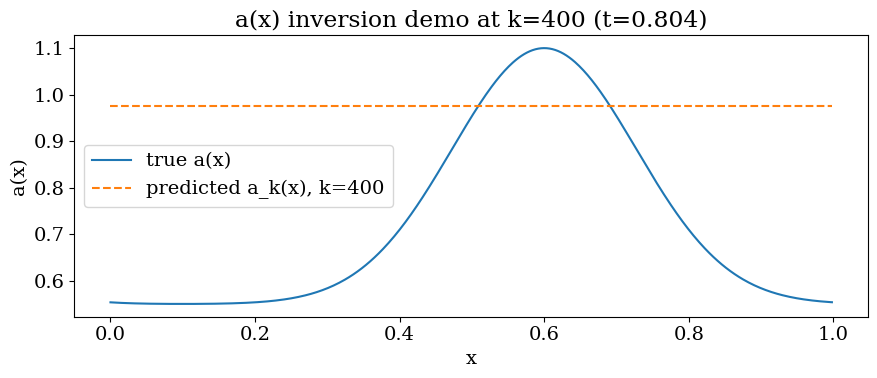

k_plot=400 | rel_err=4.202e-01
true_theta   = [0.55 0.55 0.6  0.18]
theta_hat[k] = [0.97460937 0.         0.58027374 0.5       ]


In [40]:
# ---- demo plot: choose k_plot (changeable) ----
k_plot = 400   # <--- YOU CAN CHANGE THIS
k_plot = int(np.clip(k_plot, 0, len(t_uniform)-2))

a_true = a_from_theta(x_grid, true_theta, L)
a_pred = a_hat_hist[k_plot]

plt.figure(figsize=(9,4))
plt.plot(x_grid, a_true, label="true a(x)")
plt.plot(x_grid, a_pred, "--", label=f"predicted a_k(x), k={k_plot}")
plt.title(f"a(x) inversion demo at k={k_plot} (t={t_uniform[k_plot+1]:.3f})")
plt.xlabel("x")
plt.ylabel("a(x)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"k_plot={k_plot} | rel_err={rel_err_hist[k_plot]:.3e}")
print("true_theta   =", true_theta)
print("theta_hat[k] =", theta_hat_hist[k_plot])

## 2nd attemp: first attempt + regularization

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ----------------------------
# Regularization terms
# ----------------------------
def smoothness_penalty(a_vec, dx):
    da = (np.roll(a_vec, -1) - a_vec) / dx
    return np.sum(da**2) * dx

def sigma_barrier(theta, sigma_ref, p=2):
    sigma = float(theta[3])
    return (sigma_ref / max(sigma, 1e-12))**p

# ----------------------------
# Regularized objective
# ----------------------------
def objective_reg(theta, Vk, Vkp1, x_grid, dt, L, t_arrival, eps,
                  lam_smooth, lam_sigma, sigma_ref, p_sigma,
                  a_from_theta, departure_points_backward_euler,
                  apply_shift_to_basis, dx):
    # fit term
    x_dep = departure_points_backward_euler(theta, x_grid, dt, L, t_arrival, eps)
    S_Vk = apply_shift_to_basis(Vk, x_dep, L)
    Ared = Vkp1.T @ S_Vk
    fit = -np.linalg.norm(Ared, ord="fro")**2

    # regularization
    a_vec = a_from_theta(x_grid, theta, L)
    reg_smooth = lam_smooth * smoothness_penalty(a_vec, dx)
    reg_sigma  = lam_sigma  * sigma_barrier(theta, sigma_ref=sigma_ref, p=p_sigma)

    return fit + reg_smooth + reg_sigma

# ----------------------------
# Per-k inversion loop (regularized)
# ----------------------------
def invert_a_per_timestep_regularized(
    x_grid, L, t_uniform, Vr_u_hist, eps,
    theta_init, bounds,
    lam_smooth=5e-2,
    lam_sigma=1e-1,
    sigma_ref=0.18,
    p_sigma=2,
    maxiter=60,
    ftol=1e-10,
    true_theta=None,
    a_from_theta=None,
    departure_points_backward_euler=None,
    apply_shift_to_basis=None
):
    x_grid = np.asarray(x_grid)
    K = len(t_uniform)
    dt_k = float(t_uniform[1] - t_uniform[0])
    dx = L / x_grid.size

    theta_hat_hist = np.zeros((K-1, 4), dtype=float)
    a_hat_hist = np.zeros((K-1, x_grid.size), dtype=float)
    rel_err_hist = np.full(K-1, np.nan, dtype=float)

    if true_theta is not None:
        a_true = a_from_theta(x_grid, true_theta, L)
        denom = np.sqrt(np.sum(a_true**2) * dx) + 1e-14
    else:
        a_true = None
        denom = None

    theta_prev = np.array(theta_init, dtype=float)

    for k in range(K-1):
        Vk = Vr_u_hist[k]
        Vkp1 = Vr_u_hist[k+1]
        t_arrival = float(t_uniform[k+1])

        res = minimize(
            objective_reg,
            x0=theta_prev,
            args=(Vk, Vkp1, x_grid, dt_k, L, t_arrival, eps,
                  lam_smooth, lam_sigma, sigma_ref, p_sigma,
                  a_from_theta, departure_points_backward_euler,
                  apply_shift_to_basis, dx),
            method="L-BFGS-B",
            bounds=bounds,
            options={"maxiter": maxiter, "ftol": ftol}
        )

        theta_hat = res.x
        theta_hat_hist[k, :] = theta_hat

        a_hat = a_from_theta(x_grid, theta_hat, L)
        a_hat_hist[k, :] = a_hat

        if a_true is not None:
            num = np.sqrt(np.sum((a_hat - a_true)**2) * dx)
            rel_err_hist[k] = num / denom

        theta_prev = theta_hat  # warm start

    return theta_hat_hist, a_hat_hist, rel_err_hist


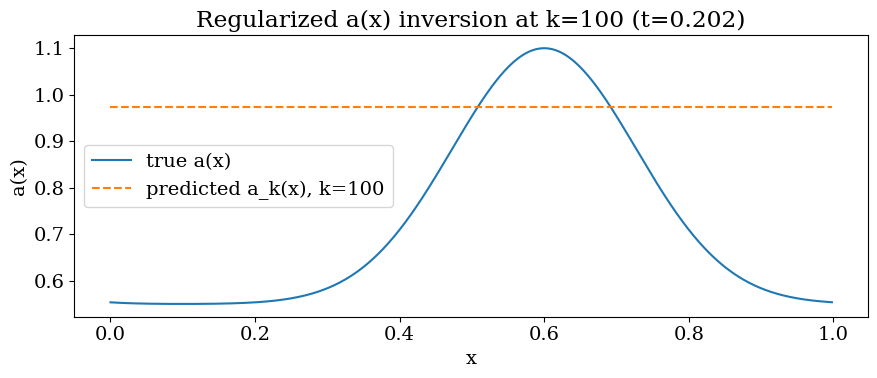

In [43]:
# ---- demo plot: choose k_plot (changeable) ----
k_plot = 100  # <--- YOU CAN CHANGE THIS
k_plot = int(np.clip(k_plot, 0, len(t_uniform)-2))

a_true = a_from_theta(x_grid, true_theta, L)
a_pred = a_hat_hist[k_plot]

plt.figure(figsize=(9,4))
plt.plot(x_grid, a_true, label="true a(x)")
plt.plot(x_grid, a_pred, "--", label=f"predicted a_k(x), k={k_plot}")
plt.title(f"Regularized a(x) inversion at k={k_plot} (t={t_uniform[k_plot+1]:.3f})")
plt.xlabel("x")
plt.ylabel("a(x)")
plt.legend()
plt.tight_layout()
plt.show()


## 3rd Attempt: Changing objective function to data misfit


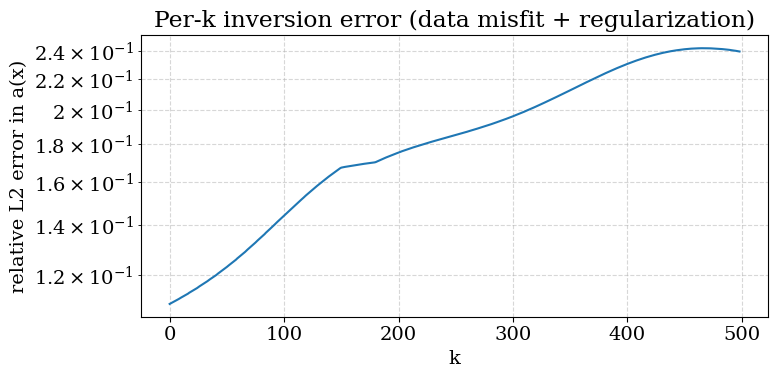

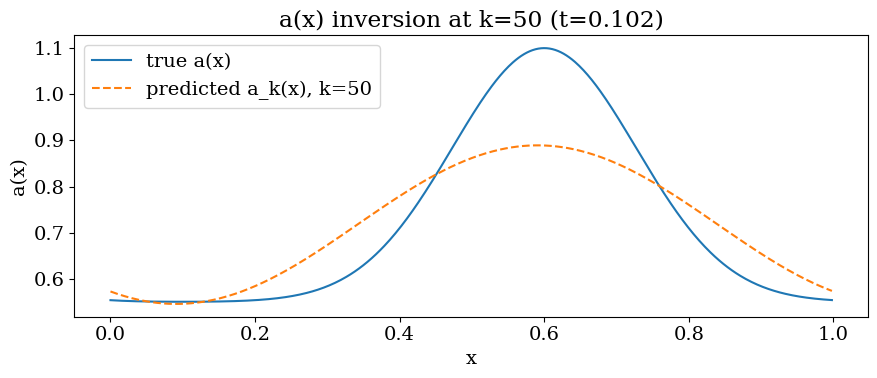

k_plot=50 | rel_err=1.230e-01
theta_hat[k] = [0.         0.87268023 0.59087464 0.46374069]


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ----------------------------
# Parameterization a(x;theta) = base + amp * periodic_gaussian(x;mu,sigma)
# ----------------------------
def periodic_gaussian(x, mu, sigma, L):
    return (np.exp(-((x - mu)/sigma)**2)
          + np.exp(-((x - (mu - L))/sigma)**2)
          + np.exp(-((x - (mu + L))/sigma)**2))

def a_from_theta(x, theta, L):
    a_base, a_amp, mu, sigma = theta
    return a_base + a_amp * periodic_gaussian(x % L, mu, sigma, L)

# ----------------------------
# Periodic linear interpolation on uniform grid
# ----------------------------
def interp_periodic_1d(u, xq, L):
    u = np.asarray(u)
    xq = np.mod(np.asarray(xq), L)
    N = u.size
    dx = L / N
    i0 = np.floor(xq / dx).astype(int) % N
    frac = (xq - i0*dx) / dx
    return (1 - frac) * u[i0] + frac * u[(i0 + 1) % N]

# ----------------------------
# FIX 3: correct departure points via backward-Euler in x (arrival -> departure)
# x_dep = x_arr - dt * a(x_dep) * exp(-eps * t_arrival)
# ----------------------------
def departure_points_backward_euler(theta, x_arr, dt, L, t_arrival, eps,
                                    n_iter=25, tol=1e-12):
    x_arr = np.asarray(x_arr)
    fac = np.exp(-eps * t_arrival)

    # initial guess: explicit backtrace
    xdep = (x_arr - dt * a_from_theta(x_arr, theta, L) * fac) % L

    for _ in range(n_iter):
        xnew = (x_arr - dt * a_from_theta(xdep, theta, L) * fac) % L
        if np.max(np.abs(xnew - xdep)) < tol:
            xdep = xnew
            break
        xdep = xnew
    return xdep

# ----------------------------
# Apply T_k(a) to a snapshot matrix U_k (N,M): columnwise interpolation
# ----------------------------
def apply_shift_to_snapshots(Uk, x_dep, L):
    """
    Apply T_k(a) to snapshot matrix Uk using periodic interpolation.

    Accepts Uk shaped (N,M) or (M,N).
    Returns same shape orientation as input.
    """
    Uk = np.asarray(Uk)
    x_dep = np.asarray(x_dep)

    if Uk.ndim != 2:
        raise ValueError(f"Uk must be 2D, got shape {Uk.shape}")

    # Case 1: Uk is (N,M)
    if Uk.shape[0] == x_dep.size:
        N, M = Uk.shape
        TUk = np.empty_like(Uk)
        for m in range(M):
            TUk[:, m] = interp_periodic_1d(Uk[:, m], x_dep, L)
        return TUk

    # Case 2: Uk is (M,N) -> shift each row and return (M,N)
    if Uk.shape[1] == x_dep.size:
        M, N = Uk.shape
        TUk = np.empty_like(Uk)
        for m in range(M):
            TUk[m, :] = interp_periodic_1d(Uk[m, :], x_dep, L)
        return TUk

    raise ValueError(
        f"Shape mismatch: Uk shape {Uk.shape}, but x_dep has length {x_dep.size}. "
        "Expected Uk to be (N,M) or (M,N) with N=len(x_dep)."
    )


# ----------------------------
# Regularization
# ----------------------------
def smoothness_penalty(a_vec, dx):
    da = (np.roll(a_vec, -1) - a_vec) / dx
    return np.sum(da**2) * dx

def sigma_barrier(theta, sigma_ref, p=2):
    sigma = float(theta[3])
    return (sigma_ref / max(sigma, 1e-12))**p

# ----------------------------
# FIX 1: data misfit objective per k
# J_k(theta) = ||U_{k+1} - T_k(a(theta)) U_k||_F^2 + regs
# ----------------------------
def objective_data_misfit_reg(theta, Uk, Ukp1, x_grid, dt, L, t_arrival, eps,
                             lam_smooth, lam_sigma, sigma_ref, p_sigma):
    dx = L / x_grid.size

    # build T_k(a(theta)) via departure points
    x_dep = departure_points_backward_euler(theta, x_grid, dt, L, t_arrival, eps)
    TUk = apply_shift_to_snapshots(Uk, x_dep, L)

    # data misfit
    misfit = np.linalg.norm(Ukp1 - TUk, ord="fro")**2

    # regularization
    a_vec = a_from_theta(x_grid, theta, L)
    reg_s = lam_smooth * smoothness_penalty(a_vec, dx)
    reg_b = lam_sigma  * sigma_barrier(theta, sigma_ref=sigma_ref, p=p_sigma)

    return misfit + reg_s + reg_b

# ----------------------------
# Invert per k and save a_hat_k(x) + error per step
# ----------------------------
def invert_a_per_k_data_misfit(
    u_hist_tensor, x_grid, L, t_uniform, eps,
    theta_init, bounds,
    lam_smooth=1e-2,
    lam_sigma=1e-1,
    sigma_ref=0.18,
    p_sigma=2,
    maxiter=80,
    ftol=1e-10,
    a_true=None
):
    # u_hist_tensor can be (N,M,K) or (M,N,K)
    Ngrid = x_grid.size
    K = u_hist_tensor.shape[2]
    dt = float(t_uniform[1] - t_uniform[0])
    dx = L / Ngrid

    theta_hat_hist = np.zeros((K-1, 4))
    a_hat_hist = np.zeros((K-1, N))
    rel_err_hist = np.full(K-1, np.nan)

    if a_true is not None:
        denom = np.sqrt(np.sum(a_true**2) * dx) + 1e-14

    theta_prev = np.array(theta_init, dtype=float)

    for k in range(K-1):
        Uk   = u_hist_tensor[:, :, k]
        Ukp1 = u_hist_tensor[:, :, k+1]
        t_arrival = float(t_uniform[k+1])

        res = minimize(
            objective_data_misfit_reg,
            x0=theta_prev,
            args=(Uk, Ukp1, x_grid, dt, L, t_arrival, eps,
                  lam_smooth, lam_sigma, sigma_ref, p_sigma),
            method="L-BFGS-B",
            bounds=bounds,
            options={"maxiter": maxiter, "ftol": ftol}
        )

        theta_hat = res.x
        theta_hat_hist[k, :] = theta_hat
        a_hat = a_from_theta(x_grid, theta_hat, L)
        a_hat_hist[k, :] = a_hat

        if a_true is not None:
            num = np.sqrt(np.sum((a_hat - a_true)**2) * dx)
            rel_err_hist[k] = num / denom

        # warm start
        theta_prev = theta_hat

    return theta_hat_hist, a_hat_hist, rel_err_hist

# ============================================================
# USAGE (you already have u_hist_tensor and true a(x) from the forward run)
# ============================================================

# Example true a(x) (replace with your actual known a_adv if you have it)
# a_true = a_adv.copy()

# Initial guess + bounds (same style as before)
theta0 = np.array([0.6, 0.4, 0.5*L, 0.15*L], dtype=float)
bounds = [(0.0, 2.5), (0.0, 2.5), (0.0, L), (0.01*L, 0.5*L)]

theta_hat_hist, a_hat_hist, rel_err_hist = invert_a_per_k_data_misfit(
    u_hist_tensor=u_hist_tensor,
    x_grid=x_grid,
    L=L,
    t_uniform=t_uniform,
    eps=eps,
    theta_init=theta0,
    bounds=bounds,
    lam_smooth=5e-2,
    lam_sigma=1e-1,
    sigma_ref=0.18*L,
    p_sigma=2,
    maxiter=80,
    ftol=1e-10,
    a_true=a_true  # pass None if you don't want error
)

# --- error per k ---
plt.figure(figsize=(8,4))
plt.semilogy(rel_err_hist + 1e-18)
plt.title("Per-k inversion error (data misfit + regularization)")
plt.xlabel("k")
plt.ylabel("relative L2 error in a(x)")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --- demo plot for selectable k_plot ---
k_plot = 50  # <--- change this freely
k_plot = int(np.clip(k_plot, 0, len(t_uniform)-2))

plt.figure(figsize=(9,4))
plt.plot(x_grid, a_true, label="true a(x)")
plt.plot(x_grid, a_hat_hist[k_plot], "--", label=f"predicted a_k(x), k={k_plot}")
plt.title(f"a(x) inversion at k={k_plot} (t={t_uniform[k_plot+1]:.3f})")
plt.xlabel("x")
plt.ylabel("a(x)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"k_plot={k_plot} | rel_err={rel_err_hist[k_plot]:.3e}")
print("theta_hat[k] =", theta_hat_hist[k_plot])


# 4th attempt: keep objective and changes of 3rd, but now we assume no structure for a(x)


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ------------------------------------------------------------
# Periodic linear interpolation on uniform grid [0,L)
# ------------------------------------------------------------
def interp_periodic_on_grid(values_on_grid, xq, L):
    """
    values_on_grid: (N,)
    xq: array-like points in [0,L) (will be modded)
    """
    v = np.asarray(values_on_grid)
    xq = np.mod(np.asarray(xq), L)
    N = v.size
    dx = L / N
    i0 = np.floor(xq / dx).astype(int) % N
    frac = (xq - i0*dx) / dx
    return (1 - frac) * v[i0] + frac * v[(i0 + 1) % N]

# ------------------------------------------------------------
# Fix 3: departure points for general a(x) stored on grid
# Backward-Euler in space: x_dep = x_arr - dt * a(x_dep) * exp(-eps*t_arr)
# ------------------------------------------------------------
def departure_points_BE_from_avec(a_vec, x_arr, dt, L, t_arrival, eps,
                                 n_iter=30, tol=1e-12):
    x_arr = np.asarray(x_arr)
    fac = np.exp(-eps * t_arrival)

    # initial guess: explicit backtrace using a(x_arr)
    a_at_x = interp_periodic_on_grid(a_vec, x_arr, L)
    xdep = (x_arr - dt * a_at_x * fac) % L

    for _ in range(n_iter):
        a_at_xdep = interp_periodic_on_grid(a_vec, xdep, L)
        xnew = (x_arr - dt * a_at_xdep * fac) % L
        if np.max(np.abs(xnew - xdep)) < tol:
            xdep = xnew
            break
        xdep = xnew
    return xdep

# ------------------------------------------------------------
# Apply T_k(a) to snapshot matrix Uk (supports (N,M) or (M,N))
# ------------------------------------------------------------
def apply_shift_to_snapshots(Uk, x_dep, L):
    Uk = np.asarray(Uk)
    x_dep = np.asarray(x_dep)

    # (N,M)
    if Uk.shape[0] == x_dep.size:
        N, M = Uk.shape
        TUk = np.empty_like(Uk)
        for m in range(M):
            TUk[:, m] = interp_periodic_on_grid(Uk[:, m], x_dep, L)
        return TUk

    # (M,N)
    if Uk.shape[1] == x_dep.size:
        M, N = Uk.shape
        TUk = np.empty_like(Uk)
        for m in range(M):
            TUk[m, :] = interp_periodic_on_grid(Uk[m, :], x_dep, L)
        return TUk

    raise ValueError(f"Uk shape {Uk.shape} incompatible with x_dep length {x_dep.size}")

# ------------------------------------------------------------
# H^1 periodic smoothness penalty: ||Da||_2^2
# ------------------------------------------------------------
def H1_penalty(a_vec, dx):
    da = (np.roll(a_vec, -1) - a_vec) / dx
    return np.sum(da**2) * dx

# ------------------------------------------------------------
# Per-k objective: data misfit + lambda * H1
# ------------------------------------------------------------
def objective_avec(a_vec, Uk, Ukp1, x_grid, dt, L, t_arrival, eps, lam_H1):
    dx = L / x_grid.size

    x_dep = departure_points_BE_from_avec(a_vec, x_grid, dt, L, t_arrival, eps)
    TUk = apply_shift_to_snapshots(Uk, x_dep, L)

    misfit = np.linalg.norm(Ukp1 - TUk, ord="fro")**2
    reg = lam_H1 * H1_penalty(a_vec, dx)
    return misfit + reg

# ------------------------------------------------------------
# Invert for a_k (grid vector) for each k, save a_hat and errors
# ------------------------------------------------------------
def invert_a_per_k_nonparametric(
    u_hist_tensor, x_grid, L, t_uniform, eps,
    a_init, a_bounds=(0.0, 3.0),
    lam_H1=1e-2,
    maxiter=60,
    ftol=1e-10,
    a_true=None
):
    """
    u_hist_tensor: snapshots, either (N,M,K) or (M,N,K)
    a_init: (N,) initial guess for a
    a_bounds: tuple (amin, amax) applied to all grid entries
    """
    x_grid = np.asarray(x_grid)
    Ngrid = x_grid.size
    K = u_hist_tensor.shape[2]
    dt = float(t_uniform[1] - t_uniform[0])
    dx = L / Ngrid

    a_hat_hist = np.zeros((K-1, Ngrid), dtype=float)
    rel_err_hist = np.full(K-1, np.nan, dtype=float)

    bounds = [a_bounds] * Ngrid

    if a_true is not None:
        denom = np.sqrt(np.sum(a_true**2) * dx) + 1e-14

    a_prev = np.asarray(a_init, dtype=float).copy()

    for k in range(K-1):
        Uk   = u_hist_tensor[:, :, k]
        Ukp1 = u_hist_tensor[:, :, k+1]
        t_arrival = float(t_uniform[k+1])

        res = minimize(
            objective_avec,
            x0=a_prev,
            args=(Uk, Ukp1, x_grid, dt, L, t_arrival, eps, lam_H1),
            method="L-BFGS-B",
            bounds=bounds,
            jac="2-point",  # finite-difference gradient (expensive but structure-free)
            options={"maxiter": maxiter, "ftol": ftol}
        )

        a_hat = res.x
        a_hat_hist[k, :] = a_hat

        if a_true is not None:
            num = np.sqrt(np.sum((a_hat - a_true)**2) * dx)
            rel_err_hist[k] = num / denom

        a_prev = a_hat  # warm-start

        if (k % 20) == 0 or k == K-2:
            msg = f"k={k:4d}/{K-2} | J={res.fun:.3e}"
            if a_true is not None:
                msg += f" | rel_err={rel_err_hist[k]:.3e}"
            print(msg)

    return a_hat_hist, rel_err_hist

### single timestep

[single-k] k=50 | success=False | iters=25 | fval=4.442e-03 | time=19.48s


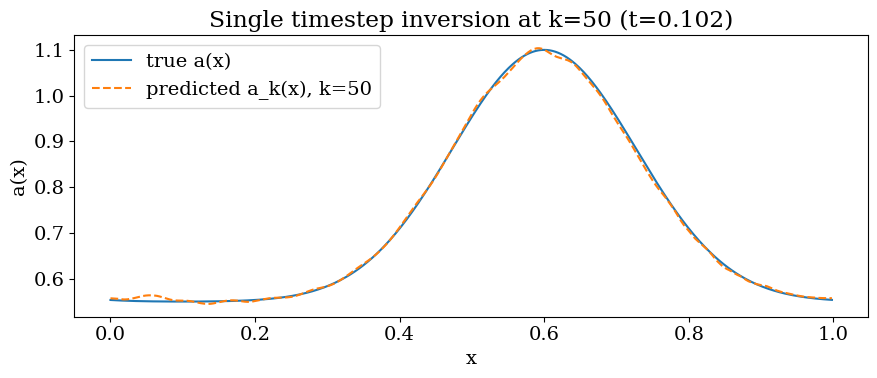

relative L2 error: 0.0065696410853688415


In [53]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def invert_a_single_k(
    k_solve,
    u_hist_tensor, x_grid, L, t_uniform, eps,
    a_init,
    a_bounds=(0.0, 3.0),
    lam_H1=1e-2,
    maxiter=40,
    ftol=1e-10,
    verbose=True
):
    """
    Solve the nonparametric inverse problem for ONE timestep k_solve:
        min_a ||U_{k+1} - T_k(a) U_k||_F^2 + lam_H1 * ||Da||_2^2

    Returns:
        a_hat (N,), fval, elapsed_sec, success_flag
    """
    x_grid = np.asarray(x_grid)
    Ngrid = x_grid.size
    K = u_hist_tensor.shape[2]
    if not (0 <= k_solve <= K-2):
        raise ValueError(f"k_solve must be in [0, {K-2}], got {k_solve}")

    dt = float(t_uniform[1] - t_uniform[0])
    bounds = [a_bounds] * Ngrid

    Uk   = u_hist_tensor[:, :, k_solve]
    Ukp1 = u_hist_tensor[:, :, k_solve + 1]
    t_arrival = float(t_uniform[k_solve + 1])

    t0 = time.perf_counter()
    res = minimize(
        objective_avec,
        x0=np.asarray(a_init, dtype=float),
        args=(Uk, Ukp1, x_grid, dt, L, t_arrival, eps, lam_H1),
        method="L-BFGS-B",
        bounds=bounds,
        jac="2-point",  # finite difference gradient
        options={"maxiter": maxiter, "ftol": ftol}
    )
    t1 = time.perf_counter()

    if verbose:
        print(f"[single-k] k={k_solve} | success={res.success} | "
              f"iters={res.nit} | fval={res.fun:.3e} | time={t1-t0:.2f}s")

    return res.x, float(res.fun), (t1 - t0), bool(res.success)


# ============================
# USAGE
# ============================

# Choose ONE timestep to invert
k_solve = 50   # <--- change this

# Initial guess for a(x)
a_init = 0.8 * np.ones_like(x_grid)

a_hat_k, fval, sec, ok = invert_a_single_k(
    k_solve=k_solve,
    u_hist_tensor=u_hist_tensor,
    x_grid=x_grid,
    L=L,
    t_uniform=t_uniform,
    eps=eps,
    a_init=a_init,
    a_bounds=(0.0, 3.0),
    lam_H1=5e-4,
    maxiter=25,      # keep small for a quick test
    ftol=1e-10,
    verbose=True
)

# Plot predicted vs true if you have a_true
plt.figure(figsize=(9,4))
plt.plot(x_grid, a_true, label="true a(x)")
plt.plot(x_grid, a_hat_k, "--", label=f"predicted a_k(x), k={k_solve}")
plt.title(f"Single timestep inversion at k={k_solve} (t={t_uniform[k_solve+1]:.3f})")
plt.xlabel("x")
plt.ylabel("a(x)")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: print relative L2 error
dx = L / x_grid.size
den = np.sqrt(np.sum(a_true**2) * dx) + 1e-14
num = np.sqrt(np.sum((a_hat_k - a_true)**2) * dx)
print("relative L2 error:", num / den)


In [51]:
for lam in [1e-1, 5e-2, 1e-2, 5e-3, 1e-3]:
    a_hat_k, fval, sec, ok = invert_a_single_k(
        k_solve=k_solve,
        u_hist_tensor=u_hist_tensor,
        x_grid=x_grid, L=L, t_uniform=t_uniform, eps=eps,
        a_init=a_init,
        a_bounds=(0.0, 3.0),
        lam_H1=lam,
        maxiter=30,
        ftol=1e-10,
        verbose=True
    )
    dx = L / x_grid.size
    rel = np.sqrt(np.sum((a_hat_k-a_true)**2)*dx) / (np.sqrt(np.sum(a_true**2)*dx)+1e-14)
    print("lam_H1 =", lam, "rel_err =", rel)


[single-k] k=50 | success=False | iters=26 | fval=1.200e-01 | time=19.48s
lam_H1 = 0.1 rel_err = 0.17676228595943358
[single-k] k=50 | success=False | iters=27 | fval=8.867e-02 | time=37.15s
lam_H1 = 0.05 rel_err = 0.1406723217704372
[single-k] k=50 | success=False | iters=26 | fval=3.111e-02 | time=19.68s
lam_H1 = 0.01 rel_err = 0.06292880769741968
[single-k] k=50 | success=False | iters=25 | fval=1.726e-02 | time=19.87s
lam_H1 = 0.005 rel_err = 0.039787735358034246
[single-k] k=50 | success=False | iters=26 | fval=5.624e-03 | time=19.41s
lam_H1 = 0.001 rel_err = 0.009544873264344125


### Parallel

In [48]:
import time
import numpy as np
from joblib import Parallel, delayed, dump, load
from scipy.optimize import minimize

# ---- assumes you already defined these from earlier code ----
# objective_avec(a_vec, Uk, Ukp1, x_grid, dt, L, t_arrival, eps, lam_H1)
# (and inside objective_avec you call departure_points_BE_from_avec etc.)

def solve_one_k_timed(
    k, u_hist_mmap, x_grid, L, t_uniform, eps,
    a_init, a_bounds, lam_H1, maxiter, ftol,
    a_true=None
):
    """
    Solve the inverse problem for a single k.
    Returns:
        (k, a_hat_k, rel_err_k, seconds_for_this_k, success_flag, final_obj)
    """
    t0 = time.perf_counter()

    x_grid = np.asarray(x_grid)
    Ngrid = x_grid.size
    dt = float(t_uniform[1] - t_uniform[0])
    dx = L / Ngrid

    Uk   = u_hist_mmap[:, :, k]
    Ukp1 = u_hist_mmap[:, :, k+1]
    t_arrival = float(t_uniform[k+1])

    bounds = [a_bounds] * Ngrid

    res = minimize(
        objective_avec,
        x0=np.asarray(a_init, dtype=float),
        args=(Uk, Ukp1, x_grid, dt, L, t_arrival, eps, lam_H1),
        method="L-BFGS-B",
        bounds=bounds,
        jac="2-point",  # finite-difference gradient
        options={"maxiter": maxiter, "ftol": ftol}
    )

    a_hat_k = res.x

    if a_true is not None:
        denom = np.sqrt(np.sum(a_true**2) * dx) + 1e-14
        num = np.sqrt(np.sum((a_hat_k - a_true)**2) * dx)
        rel_err_k = num / denom
    else:
        rel_err_k = np.nan

    t1 = time.perf_counter()
    return k, a_hat_k, rel_err_k, (t1 - t0), bool(res.success), float(res.fun)


def invert_a_per_k_nonparametric_parallel_timed(
    u_hist_tensor, x_grid, L, t_uniform, eps,
    a_init, a_bounds=(0.0, 3.0),
    lam_H1=1e-2,
    maxiter=60,
    ftol=1e-10,
    a_true=None,
    n_jobs=-1,
    backend="loky",          # "loky" (processes) or "threading"
    verbose=10,
    mmap_folder="/tmp",
    mmap_name="u_hist_tensor_mmap.pkl"
):
    """
    Parallel per-k inversion with progress + timing summary.
    Returns:
        a_hat_hist: (K-1, N)
        rel_err_hist: (K-1,)
        info: dict with timing and success stats
    """
    # ---- Memmap snapshots to avoid copying to workers ----
    mmap_path = f"{mmap_folder.rstrip('/')}/{mmap_name}"
    dump(u_hist_tensor, mmap_path)
    u_hist_mmap = load(mmap_path, mmap_mode="r")

    Ngrid = x_grid.size
    K = u_hist_mmap.shape[2]
    if K != len(t_uniform):
        raise ValueError(f"Mismatch: u_hist_tensor has K={K}, t_uniform has {len(t_uniform)}")

    # ---- Run parallel and time total wall time ----
    wall0 = time.perf_counter()

    results = Parallel(n_jobs=n_jobs, backend=backend, verbose=verbose)(
        delayed(solve_one_k_timed)(
            k, u_hist_mmap, x_grid, L, t_uniform, eps,
            a_init, a_bounds, lam_H1, maxiter, ftol,
            a_true
        )
        for k in range(K - 1)
    )

    wall1 = time.perf_counter()
    wall_time = wall1 - wall0

    # ---- Collect results ----
    a_hat_hist = np.zeros((K-1, Ngrid), dtype=float)
    rel_err_hist = np.full(K-1, np.nan, dtype=float)

    per_k_sec = np.zeros(K-1, dtype=float)
    success = np.zeros(K-1, dtype=bool)
    final_obj = np.zeros(K-1, dtype=float)

    for (k, a_hat_k, rel_err_k, sec_k, ok, fval) in results:
        a_hat_hist[k, :] = a_hat_k
        rel_err_hist[k] = rel_err_k
        per_k_sec[k] = sec_k
        success[k] = ok
        final_obj[k] = fval

    # ---- Timing / progress summary ----
    info = {
        "wall_time_sec": wall_time,
        "per_k_sec_min": float(np.min(per_k_sec)),
        "per_k_sec_med": float(np.median(per_k_sec)),
        "per_k_sec_max": float(np.max(per_k_sec)),
        "avg_sec_per_k": float(np.mean(per_k_sec)),
        "n_steps": int(K-1),
        "n_success": int(np.sum(success)),
        "n_fail": int(np.sum(~success)),
    }

    print("\n========== Parallel inversion summary ==========")
    print(f"Total k steps          : {info['n_steps']}")
    print(f"Success / Fail         : {info['n_success']} / {info['n_fail']}")
    print(f"Total wall time (sec)  : {info['wall_time_sec']:.2f}")
    print(f"Avg sec per k          : {info['avg_sec_per_k']:.3f}")
    print(f"Per-k sec (min/med/max): "
          f"{info['per_k_sec_min']:.3f} / {info['per_k_sec_med']:.3f} / {info['per_k_sec_max']:.3f}")
    print("==============================================\n")

    return a_hat_hist, rel_err_hist, info


In [49]:
a_init = 0.8 * np.ones_like(x_grid)

a_hat_hist, rel_err_hist, info = invert_a_per_k_nonparametric_parallel_timed(
    u_hist_tensor=u_hist_tensor,
    x_grid=x_grid,
    L=L,
    t_uniform=t_uniform,
    eps=eps,
    a_init=a_init,
    a_bounds=(0.0, 3.0),
    lam_H1=5e-2,
    maxiter=40,
    ftol=1e-10,
    a_true=a_true,     # or None
    n_jobs=-1,
    backend="loky",
    verbose=10         # <-- this is your live "done X tasks" progress
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 21

KeyboardInterrupt: 

### Not parallel

In [ ]:
# ============================================================
# USAGE
# ============================================================
# You already have:
#   u_hist_tensor, x_grid, L, t_uniform, eps, and a_true (optional)
#
# Provide an initial guess a_init. Common choice: constant or smoothed estimate.
# ============================================================

# Example initial guess: constant field
a_init = 0.8 * np.ones_like(x_grid)

# Run inversion
a_hat_hist, rel_err_hist = invert_a_per_k_nonparametric(
    u_hist_tensor=u_hist_tensor,
    x_grid=x_grid,
    L=L,
    t_uniform=t_uniform,
    eps=eps,
    a_init=a_init,
    a_bounds=(0.0, 3.0),
    lam_H1=5e-2,      # tune
    maxiter=40,       # tune (increase for better convergence)
    ftol=1e-10,
    a_true=a_true     # or None if you don't want error
)

# Error plot
plt.figure(figsize=(8,4))
plt.semilogy(rel_err_hist + 1e-18)
plt.title("Per-k nonparametric inversion: relative L2 error in a(x)")
plt.xlabel("k")
plt.ylabel("relative L2 error")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Demo plot at changeable k_plot
k_plot = 50  # <--- change this
k_plot = int(np.clip(k_plot, 0, len(t_uniform)-2))

plt.figure(figsize=(9,4))
plt.plot(x_grid, a_true, label="true a(x)")
plt.plot(x_grid, a_hat_hist[k_plot], "--", label=f"predicted a_k(x), k={k_plot}")
plt.title(f"Nonparametric a(x) inversion at k={k_plot} (t={t_uniform[k_plot+1]:.3f})")
plt.xlabel("x")
plt.ylabel("a(x)")
plt.legend()
plt.tight_layout()
plt.show()


# Dump


In [ ]:

# ----------------------------
# Run ALL simulations (simple loop; you can swap joblib here if you want)
# This produces u_hist_tensor: (N, M, nt_uniform) for your POD workflow
# ----------------------------
u_uniform_list = []
t_hist_list = []
U_hist_list = []
dt_hist_list = []

print(f"Running {M} simulations (RK4 + upwind + CFL dt)...")
for m in range(M):
    u_uniform, t_hist_np, U_hist_np, dt_hist_np = run_single_simulation(
        u0_mat[:, m],
        x_grid,
        a_adv,
        CFL, dx, tEnd, t_uniform,
        eps
    )
    u_uniform_list.append(u_uniform)
    t_hist_list.append(t_hist_np)
    U_hist_list.append(U_hist_np)
    dt_hist_list.append(dt_hist_np)

print("Completed simulations.")

# Stack into tensor: (N, M, nt_uniform)
u_hist_tensor = np.stack(u_uniform_list, axis=1).astype(np.float64)
print("u_hist_tensor shape:", u_hist_tensor.shape)  # (N, M, nt_uniform)


# ----------------------------
# Sanity plots: a(x), a few ICs, and snapshots for IC 0
# ----------------------------
plt.figure(figsize=(7.5,4))
plt.plot(x_grid, a_adv)
plt.title("Static Gaussian advection speed a_adv(x)")
plt.xlabel("x"); plt.ylabel("a(x)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4.5))
for m in [0, 1, 2, 3]:
    plt.plot(x_grid, u0_mat[:, m], label=f"IC {m}")
plt.title("Sample initial conditions u0(x)")
plt.xlabel("x"); plt.ylabel("u0")
plt.legend()
plt.tight_layout()
plt.show()

ic0 = 0
snap_ts = [0.0, 0.25, 0.5, 0.75, 1.0]
snap_idx = [int(np.argmin(np.abs(t_uniform - tt))) for tt in snap_ts]

plt.figure(figsize=(8,4.5))
for tt, si in zip(snap_ts, snap_idx):
    plt.plot(x_grid, u_hist_tensor[:, ic0, si], label=f"t={t_uniform[si]:.2f}")
plt.title("IC 0: solution snapshots u(t,x)")
plt.xlabel("x"); plt.ylabel("u")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()


# ----------------------------
# Local compression check at time index it0 (template uses 400)
# ----------------------------
it0 = 400
u_local = u_hist_tensor[:, :, it0]  # (N,M)
r_ulocal, U_ulocal, S_ulocal = svd_energy_rank(u_local, energy=0.9999)

print("\nLocal compression check:")
print(f"  it0={it0}, t={t_uniform[it0]:.4f}")
print("  rank for 99.99% energy:", float(r_ulocal))

plt.figure(figsize=(7,4))
plt.semilogy(S_ulocal, lw=1.6)
plt.title(f"Singular values of u_local at t={t_uniform[it0]:.3f}")
plt.xlabel("index")
plt.ylabel("singular value")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()


# ----------------------------
# POD bases over time + subspace drift (template style)
# Doing SVD at every time step can be heavy.
# Use pod_stride=1 for full (500 SVDs), or 5/10 for speed.
# ----------------------------
def subspace_drift(V_hist):
    """
    Compute subspace misalignment between consecutive POD bases.
    Returns E_minus, E_plus arrays of length nt_hist.
    """
    nt = len(V_hist)
    E_minus = np.zeros(nt)
    E_plus  = np.zeros(nt)
    I = np.eye(V_hist[0].shape[0], dtype=V_hist[0].dtype)

    for i in range(nt):
        V_curr = V_hist[i]

        if i > 0:
            V_prev = V_hist[i - 1]
            P_prev = V_prev @ V_prev.T
            E_minus[i] = np.linalg.norm((I - P_prev) @ V_curr, 'fro')
        else:
            E_minus[i] = np.nan

        if i < nt - 1:
            V_next = V_hist[i + 1]
            P_next = V_next @ V_next.T
            E_plus[i] = np.linalg.norm((I - P_next) @ V_curr, 'fro')
        else:
            E_plus[i] = np.nan

    return E_minus, E_plus

r = 30
pod_stride = 5   # <-- set 1 to match template exactly; 5 is much faster
time_ids = np.arange(0, nt_uniform, pod_stride)

Vr_u_hist = []

print(f"\nComputing POD bases every {pod_stride} time steps (total {len(time_ids)} SVDs)...")
for it in time_ids:
    u_local = u_hist_tensor[:, :, it]  # (N,M)
    Uu, Su, _ = np.linalg.svd(u_local, full_matrices=False)
    Vr_u = Uu[:, :r]
    Vr_u_hist.append(Vr_u)

Eminus_u, Eplus_u = subspace_drift(Vr_u_hist)

plt.figure(figsize=(8,4))
plt.semilogy(Eminus_u, lw=1.4, label=r"using the previous time step $(i-1)$")
plt.xlabel("POD time index (compressed)")
plt.ylabel("Subspace drift (Fro norm)")
plt.title(rf"Subspace drift for $u$ (rank r={r}, stride={pod_stride})")
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print("\nDone.")
